# Image Classification With Transfer Learning in Keras

In this project, we will create and train a convolutional neural network very easily with an existing CNN model, and it's pretrained weights. We will use the MobileNet version 2 model architecture along with its weights, trained on the popular Image Net data set. By using a model with pretrained weights and then training it on a new data set, we can drastically reduce the training time required to fit the model to the new data as our starting point is a model which already has learned to recognize thousands of simple and complex features from the imagenet data set. Transfer Learning essentially is fine tuning a models weights to specific tasks and is a very popular technique in machine learning. And a lot of times like in this project, weights are fine tuned only for the deeper, fully connected layers, and rest of the shallower layers are left as is.

# 1. Importing Libraries

In [1]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np
import pets

from matplotlib import pyplot as plt
%matplotlib inline

data_dir = 'data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.5.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? False


# 2. Cats vs Dogs Dataset

In [2]:
pets.download_and_extract('data', '.')

In [3]:
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_annot, count_train = pets.cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot, count_test = pets.cats_vs_dogs_annotations('data/annotations/test.txt')

print('Training examples count:', count_train)
print('Test examples count:', count_test)

Training examples count: 3680
Test examples count: 3669


In [6]:
train_annot
#test_annot

{'Abyssinian_201.jpg': 'cat',
 'Abyssinian_202.jpg': 'cat',
 'Abyssinian_204.jpg': 'cat',
 'Abyssinian_205.jpg': 'cat',
 'Abyssinian_206.jpg': 'cat',
 'Abyssinian_207.jpg': 'cat',
 'Abyssinian_20.jpg': 'cat',
 'Abyssinian_210.jpg': 'cat',
 'Abyssinian_212.jpg': 'cat',
 'Abyssinian_213.jpg': 'cat',
 'Abyssinian_215.jpg': 'cat',
 'Abyssinian_216.jpg': 'cat',
 'Abyssinian_217.jpg': 'cat',
 'Abyssinian_219.jpg': 'cat',
 'Abyssinian_21.jpg': 'cat',
 'Abyssinian_220.jpg': 'cat',
 'Abyssinian_221.jpg': 'cat',
 'Abyssinian_223.jpg': 'cat',
 'Abyssinian_224.jpg': 'cat',
 'Abyssinian_225.jpg': 'cat',
 'Abyssinian_226.jpg': 'cat',
 'Abyssinian_228.jpg': 'cat',
 'Abyssinian_22.jpg': 'cat',
 'Abyssinian_230.jpg': 'cat',
 'Abyssinian_232.jpg': 'cat',
 'Abyssinian_24.jpg': 'cat',
 'Abyssinian_25.jpg': 'cat',
 'Abyssinian_26.jpg': 'cat',
 'Abyssinian_27.jpg': 'cat',
 'Abyssinian_29.jpg': 'cat',
 'Abyssinian_2.jpg': 'cat',
 'Abyssinian_30.jpg': 'cat',
 'Abyssinian_31.jpg': 'cat',
 'Abyssinian_32.jpg': 

# 3. Get Random Batch

In [16]:
image_dir = 'data/images/'

def get_random_batch(annot, batch_size=4):
    all_keys = list(annot.keys())
    total_examples = len(all_keys)
    indices = np.random.choice(range(total_examples), batch_size)
    x = np.zeros((batch_size, 128, 128, 3))
    y = np.zeros((batch_size, 1))
    images = []
    
    for i, index in enumerate(indices):
        image_path = os.path.join(image_dir, all_keys[index])
        image = tf.keras.preprocessing.image.load_img(
            image_path, target_size=(128, 128)
        )
        images.append(image)
        arr = tf.keras.preprocessing.image.img_to_array(image)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        arr = np.expand_dims(arr, axis=0)
        x[i] = arr
        y[i] = class_to_index[annot[all_keys[index]]]
    
    return x, y, images

Displaying first 8 examples..


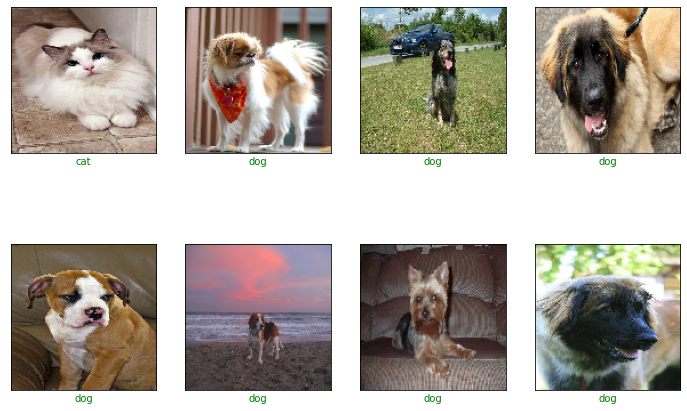

In [17]:
x, y, images = get_random_batch(train_annot, batch_size=8)
pets.display_examples(x, y, y, images, index_to_class).show()

# 4. Create Model

In [9]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, input_shape=(128, 128, 3),
                                                     pooling='avg', weights='imagenet')
mnet.summary()

9412608/9406464 [==============================] - 3s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
________________

In [10]:
def create_model():
    model = tf.keras.models.Sequential([
        mnet,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.layers[0].trainable = False
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


# 5. Model Training

In [11]:
def data_generator(batch_size, annot):
    while True:
        x, y, _ = get_random_batch(annot, batch_size)
        yield (x, y)

In [12]:
batch_size = 32
steps_per_epoch = int(len(list(train_annot.keys()))/batch_size)
validation_steps = int(len(list(test_annot.keys()))/batch_size)

print('Steps per epoch:', steps_per_epoch)
print('Validation steps:', validation_steps)

Steps per epoch: 115
Validation steps: 114


In [13]:
%%time

_ = model.fit_generator(
    data_generator(batch_size, train_annot),
    validation_data=data_generator(batch_size, test_annot),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=1
)

C:\Users\KIIT\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


115/115 [==============================] - 130s 1s/step - loss: 0.2796 - acc: 0.8834 - val_loss: 0.0991 - val_acc: 0.9734
Wall time: 2min 11s


# 6. Predictions

Displaying first 8 examples..


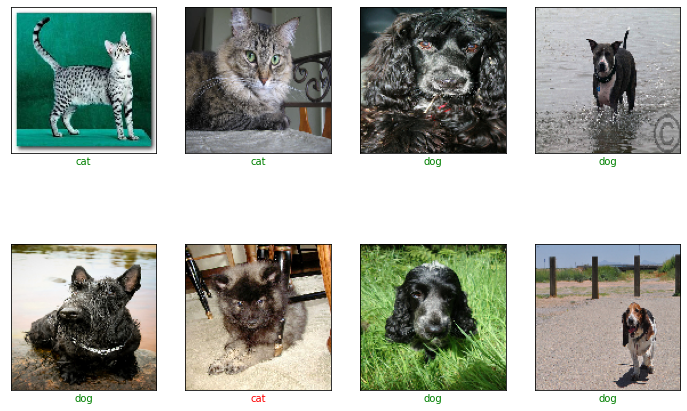

In [14]:
x, y, images = get_random_batch(test_annot, batch_size=8)
preds = model.predict(x)
pets.display_examples(x, y, preds, images, index_to_class).show()